In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from numpy import *
import cv2
import matplotlib.pyplot as plt

In [0]:
def step_sgd_mom(parameter_to_update, gradient, v, decay_factor=0.9, learning_rate=0.001):

  v = (decay_factor * v) + (1 - decay_factor) * gradient
  
  parameter_to_update -= learning_rate * v

  return [v, parameter_to_update]

def run_sgd_mom(parameter, gradient, initial_v, decay_factor=0.9, learning_rate=0.001, num_iterations=1):

  v = initial_v

  for i in range(num_iterations):
    v, parameter = step_sgd_mom(parameter, gradient, v, decay_factor, learning_rate)
  
  return [v, parameter]

CNN CODE

In [0]:
class Conv:
  def __init__(self, num_filters, filter_size):
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size * filter_size) # normalize the values

    # initialize for SGD-Mom
    self.sgd_mom_initial_v = 0
    self.sgd_mom_decay_factor = 0.9

  def image_region(self, image):
    # generator function
    height, width = image.shape
    self.image = image

    # need to vectorize this
    for i in range (height - self.filter_size + 1):
      for j in range (width - self.filter_size + 1):
        image_patch = image [i: (i + self.filter_size), j: (j + self.filter_size)]
        yield image_patch, i, j # stores all image patches
  
  def forward_prop(self, image):
    height, width = image.shape
    conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters))
    
    # need to vectorize this
    for image_patch, i, j in self.image_region(image):
      conv_out[i, j] = np.sum(image_patch * self.conv_filter, axis = (1, 2))
    return conv_out

  def back_prop(self, dL_dout, learning_rate, optimizer):

    """
    add input parameter called optimizer w/ values ('gd', 'sgd', 'sgd_mom', 'sgd_nesterov', 'adam', 'rmsprop', etc...)
    check optimizer param against the input string and run the appropriate algorithm
    should be consistent w/ the value passed to the softmax layer

    if optimizer == 'gd':
      run_gd()
    
    if optimizer == 'sgd':
      run_sgd()

    ...
    """
    dL_dF_params = np.zeros(self.conv_filter.shape)

    # need to vectorize this
    for image_patch, i, j in self.image_region(self.image):
      for k in range(self.num_filters):
        dL_dF_params[k] += image_patch * dL_dout[i,j,k]

    # stochastic gradient descent
    if optimizer == 'sgd-mom':
      self.sgd_mom_initial_v, self.conv_filter = run_sgd_mom(self.conv_filter, dL_dF_params, initial_v=self.sgd_mom_initial_v, decay_factor=self.sgd_mom_decay_factor, learning_rate=0.001, num_iterations=1)

    # ADD OTHER OPTIMIZERS HERE
    
    return dL_dF_params

In [0]:
class Max_Pool:
  def __init__(self, filter_size):
    self.filter_size = filter_size
  
  def image_region(self, image):
    new_height = image.shape[0] // self.filter_size
    new_width = image.shape[1] // self.filter_size
    self.image = image

    # need to vectorize this
    for i in range(new_height):
      for j in range(new_width):
        image_patch = image[(i*self.filter_size) : (i*self.filter_size + self.filter_size) , (j*self.filter_size) : (j*self.filter_size + self.filter_size)]
        yield image_patch, i, j

  def forward_prop(self, image):
    height, width, num_filters = image.shape
    output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    # need to vectorize this
    for image_patch, i, j in self.image_region(image):
      output[i, j] = np.amax(image_patch, axis=(0,1))

    return output 

  def back_prop(self, dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      height, width, num_filters = image_patch.shape
      maximum_val = np.amax(image_patch, axis=(0,1))

      # need to vectorize this 
      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(num_filters):
            if image_patch[i1, j1, k1] == maximum_val[k1]:
              dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k1] = dL_dout[i, j, k1]
      
      return dL_dmax_pool  

In [0]:
class SoftMax:
  def __init__(self, input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node) / input_node
    self.bias = np.zeros(softmax_node)

    # initialize for SGD-Mom
    self.sgd_mom_initial_v_w = 0
    self.sgd_mom_initial_v_b = 0
    self.sgd_mom_decay_factor = 0.9

  def forward_prop(self, image):
    self.orig_image_shape = image.shape
    modified_image = image.flatten()
    self.modified_input = modified_image
    output_val = np.dot(modified_image, self.weight) + self.bias
    self.out = output_val
    exp_out = np.exp(output_val)
    return exp_out/np.sum(exp_out, axis = 0)
  
  def back_prop(self, dL_dout, learning_rate, optimizer):

    """
    add input parameter called optimizer w/ values ('gd', 'sgd', 'sgd_mom', 'sgd_nesterov', 'adam', 'rmsprop', etc...)
    check optimizer param against the input string and run the appropriate algorithm
    should be consistent w/ the value passed to the conv layer

    if optimizer == 'gd':
      run_gd()
    """

    for i, grad in enumerate(dL_dout):
      if grad == 0:
        continue
    
      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      # Gradients w/ respect to output (z)
      dy_dz = -transformation_eq[i]*transformation_eq / (S_total ** 2)
      dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total ** 2)

      # Gradients of totals against weights/biases/input
      dz_dw = self.modified_input # against weights
      dz_db = 1 # against biases
      dz_d_inp = self.weight # against input

      # Gradients of loss against totals
      dL_dz = grad * dy_dz

      # Gradients of loss against weights/biases/input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis] # against weights (@ => matrix multiplication operator)
      dL_db = dL_dz * dz_db # against biases
      dL_d_inp = dz_d_inp @ dL_dz # against input

      if optimizer == 'sgd-mom':
        # update weights
        self.sgd_mom_initial_v_w, self.weight = run_sgd_mom(self.weight, dL_dw, initial_v=self.sgd_mom_initial_v_w, decay_factor=self.sgd_mom_decay_factor, learning_rate=0.001, num_iterations=1)

        # update biases
        self.sgd_mom_initial_v_b, self.bias = run_sgd_mom(self.bias, dL_db, initial_v=self.sgd_mom_initial_v_b, decay_factor=self.sgd_mom_decay_factor, learning_rate=0.001, num_iterations=1)

      # ADD OTHER OPTIMIZERS HERE

      """
      # Update weights and biases
      self.weight -= learning_rate * dL_dw 
      self.bias -= learning_rate * dL_db
      """

      return dL_d_inp.reshape(self.orig_image_shape)

In [0]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_images = X_train[:6000]
train_labels = y_train[:6000]
test_images = X_test[:1500]
test_labels = y_test[:1500]

conv = Conv(8, 3)
pool = Max_Pool(2)
softmax = SoftMax(13 * 13 * 8, 10)

def feed_forward(image, label):
  out = conv.forward_prop((image / 255) - 0.5)
  out = pool.forward_prop(out)
  out = softmax.forward_prop(out)

  # Calculate cross-entropy loss and accuracy
  if out[label] != 0: cross_entropy_loss = -np.log(out[label])
  else: cross_entropy_loss = 0
  if np.isnan(cross_entropy_loss) or np.isinf(cross_entropy_loss): cross_entropy_loss = 0
  accuracy = 1 if np.argmax(out) == label else 0

  return out, cross_entropy_loss, accuracy

def train(image, label, optimizer, learning_rate = 0.01):

  # Forward
  out, loss, acc = feed_forward(image, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  if out[label] != 0: gradient[label] = -1 / out[label]

  # Backpropagation
  grad_back = softmax.back_prop(gradient, learning_rate, optimizer)
  grad_back = pool.back_prop(grad_back)
  grad_back = conv.back_prop(grad_back, learning_rate, optimizer)

  return loss, acc

In [32]:
import time

num_epochs = 10
optimizer = 'sgd-mom'
learning_rate = 0.0001

print('Training the CNN....')
start = time.time()

loss = 0
num_correct = 0
lossVals = []
accuVals = []

for epoch in range(num_epochs):
  print('Epoch %d ----> ' % (epoch + 1))

  # Shuffle the training data
  shuffle_data = np.random.permutation(len(train_images))
  train_images = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  # Train the CNN
  for i, (img, label) in enumerate(zip(train_images, train_labels)):
    # print progress every 100 images 
    if i % 100 == 0:
      print('%d of 100 steps: Average loss %.3f and Accuracy: %d%%' % (i + 1, loss / ((i + 1) + epoch*6000), (num_correct * 100 / ((i + 1) + epoch*6000))))

    l1, accu = train(img, label, optimizer, learning_rate)
    
    lossVals.append(loss / ((i + 1) + epoch*6000))
    accuVals.append(num_correct * 100 / ((i + 1) + epoch*6000))

    loss += l1
    num_correct += accu

print(time.time()-start)

Training the CNN....
Epoch 1 ----> 
1 of 100 steps: Average loss 0.000 and Accuracy: 0%
101 of 100 steps: Average loss 2.272 and Accuracy: 17%
201 of 100 steps: Average loss 2.276 and Accuracy: 17%
301 of 100 steps: Average loss 2.276 and Accuracy: 18%
401 of 100 steps: Average loss 2.269 and Accuracy: 22%
501 of 100 steps: Average loss 2.264 and Accuracy: 26%
601 of 100 steps: Average loss 2.255 and Accuracy: 30%
701 of 100 steps: Average loss 2.243 and Accuracy: 32%
801 of 100 steps: Average loss 2.234 and Accuracy: 33%
901 of 100 steps: Average loss 2.228 and Accuracy: 33%
1001 of 100 steps: Average loss 2.221 and Accuracy: 34%
1101 of 100 steps: Average loss 2.214 and Accuracy: 35%
1201 of 100 steps: Average loss 2.205 and Accuracy: 36%
1301 of 100 steps: Average loss 2.198 and Accuracy: 38%
1401 of 100 steps: Average loss 2.191 and Accuracy: 39%
1501 of 100 steps: Average loss 2.183 and Accuracy: 40%
1601 of 100 steps: Average loss 2.178 and Accuracy: 41%
1701 of 100 steps: Averag

In [33]:
# Test the CNN
print('Testing the CNN....')
start = time.time()
test_lossVals = []
test_accuVals = []
loss = 0 
num_correct = 0
for i, (img, label) in enumerate(zip(test_images, test_labels)):
  _, l1, accu = feed_forward(img, label)
  loss += l1
  num_correct += accu
  test_lossVals.append(loss / (i+1))
  test_accuVals.append((num_correct * 100) / (i+1))

num_tests = len(test_images)
print('Test loss: ', loss / num_tests)
print('Test accuracy: ', num_correct / num_tests)
print(time.time() - start)

Testing the CNN....
Test loss:  0.6646799846404943
Test accuracy:  0.84
15.2178053855896


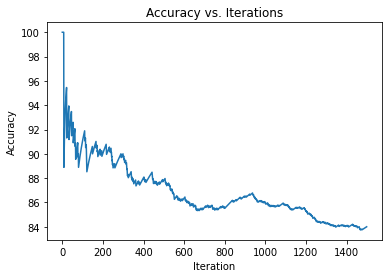

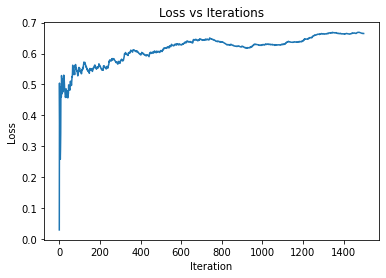

In [34]:
# Plots for testing

plt.plot(test_accuVals)
plt.title("Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

plt.plot(test_lossVals)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

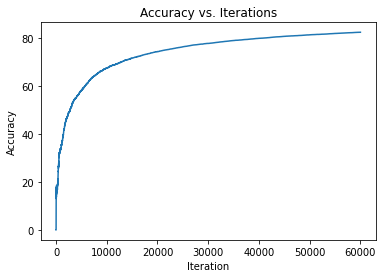

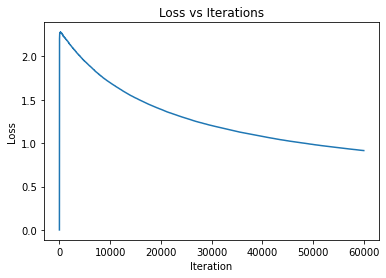

In [35]:
# Plots for training

plt.plot(accuVals)
plt.title("Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

plt.plot(lossVals)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [36]:
# Add a file called accu_loss.csv into google colab's files
# Save training accuracies and loss

import csv

with open('/content/drive/My Drive/OptML/CSVs/SGD-Mom/sgd-mom-training-0001.csv', mode='w') as accu_loss:
    accu_loss_writer = csv.writer(accu_loss, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for accu, loss in zip(accuVals, lossVals):
      accu_loss_writer.writerow([accu, loss])
  
print ("Finished writing")

Finished writing


In [37]:
# Add a file called accu_loss.csv into google colab's files
# Save testing accuracies and loss

import csv

with open('/content/drive/My Drive/OptML/CSVs/SGD-Mom/sgd-mom-testing-0001.csv', mode='w') as accu_loss:
    accu_loss_writer = csv.writer(accu_loss, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for accu, loss in zip(test_accuVals, test_lossVals):
      accu_loss_writer.writerow([accu, loss])

print ("Finished writing")

Finished writing
